MCS - BeNeFri
<br/>Social Media Analytics, Spring 2020
<br/>Project - Community Detection in a Facebook network
<br/>@authors: Guillaume Chacun, Fabien Vorpe

# Community Detection in a Facebook network

## Dataset

### Load the graph

In [1]:
import networkx as nx
from tqdm import tqdm

In [2]:
edges_filename = 'example.txt' #facebook_combined

In [3]:
# Load the Facebook dataset
graph = nx.read_edgelist(f'data/{edges_filename}')
graph = nx.gnp_random_graph(100, 0.2)

edge_list = ['%i %i {\'weight\': %i}' % (int(d[0]), int(d[1]), int(d[2])) for d in list(graph.edges.data('weight', default=1))]
graph = nx.parse_edgelist(edge_list)

### Explore the properties of the graph

In [4]:
# print number of nodes / edges
print('Number of nodes:', graph.number_of_nodes())
print('Number of edges:', graph.number_of_edges())

Number of nodes: 100
Number of edges: 950


In [5]:
import statistics
print('Average shortest path length:', nx.average_shortest_path_length(graph))
print('Average degree:', statistics.mean([graph.degree(node) for node in graph.nodes()]))
print('Radius:', nx.radius(graph))
print('Diameter:', nx.diameter(graph))
print('Density:', nx.density(graph))
#print('Eccentricity:', nx.eccentricity(graph))
#print('Center:', nx.center(graph))
#print('Periphery:', nx.periphery(graph))

Average shortest path length: 1.8307070707070707
Average degree: 19
Radius: 2
Diameter: 3
Density: 0.1919191919191919


## Algorithms implementation

### Louvain

Implement the Louvain method for community detection.  

In [6]:
def louvain_passage(graph):
    """
    Performs one passage of Louvain's algorithm to detect communities in a graph.
    :param graph: networkx graph
    :returns: dictionary with graph's nodes as keys and communities' id as values
    """
    m = sum([edge[2]['weight'] for edge in graph.edges().data()])
    prev_communities = {}
    communities = {i: i for i in graph.nodes} # keys: nodes' id, values: nodes' community id
    while list(prev_communities.values()) != list(communities.values()): # while communities are changing
        prev_communities = communities.copy()
        
        communities = {k: v for k, v in sorted(communities.items(), 
                                               key=lambda item: int(item[1]))} # sort by node id (keys)
        for nodei in tqdm(communities.keys()):
            communityi = communities[nodei]
            di = sum([graph.get_edge_data(nodei, neighbor)['weight']
                      for neighbor in graph.neighbors(nodei)])
            # can't use degree() as we're working with undirected graphs and degree() counts self loops twice
            
            neighbor_communities = set(communities[neighbor] for neighbor in graph.neighbors(nodei))
            
            # compute modularity gain for each neighbor community of nodei
            modularity_gains = {} # keys: community' id, values: modularity gain
            
            nodes_of_each_community = {}
            for node, community in communities.items():
                try:
                    nodes_of_each_community[community].append(node)
                except:
                    nodes_of_each_community[community] = [node]
                    
            for communityj in neighbor_communities:
                #nodes_in_communityj = [node for node, community in communities.items() 
                #                       if community == communityj] # modified
                nodes_in_communityj = nodes_of_each_community[communityj] # get nodes belonging to community j
                
                dj = 0
                links_ij = []
                for node in nodes_in_communityj:
                    dj += sum([graph.get_edge_data(node, neighbor)['weight'] 
                               for neighbor in graph.neighbors(node) 
                               if node != nodei])
                    # count number of neighbors of nodei that are in communityj
                    links_ij.append(graph.get_edge_data(nodei, node)['weight'] if node in graph.neighbors(nodei) else 0)
                
                #dj2 = sum([graph.get_edge_data(node, neighbor)['weight'] 
                #          for node in nodes_in_communityj
                #          for neighbor in graph.neighbors(node) 
                #          if node != nodei]) #modified
                
                #links_ij2 = [graph.get_edge_data(nodei, node)['weight'] if node in graph.neighbors(nodei) else 0 
                #            for node in nodes_in_communityj] #modified
                
                dij = 2 * sum(links_ij)
                # compute modularity gains
                modularity_gains[communityj] = 1 / (2 * m) * (dij - (di * dj / m))
                
            # update node's community
            modularity_gains = {k: v 
                                for k, v in sorted(modularity_gains.items(), 
                                                   key=lambda item: item[1])} # sort by modularity gain (values)
            communities[nodei] = list(modularity_gains.keys())[-1]
    return communities

In [7]:
def louvain_create_hypernodes(graph, communities):
    """
    Creates the hypernodes graph after one passage of Louvain's aglorithm.
    :param graph: networkx graph
    :param communities: dictionary with graph's nodes as keys and communityies' id as values
    :returns: new networkx graph (communities became hypernodes)
    """
    new_graph = nx.Graph()
    # create hypernodes and reflective edges
    for community in set(communities.values()):
        new_graph.add_node(community)

        # count number of edges in community
        nodes_in_community = [n for n, c in communities.items() if community == c]
        
        #links_intra_community = [1 if neighbor in nodes_in_community else 0 
        #                         for node in nodes_in_community
        #                         for neighbor in graph.neighbors(node)]
        links_intra_community = [graph.get_edge_data(node, neighbor)['weight'] if neighbor in nodes_in_community else 0 
                                 for node in nodes_in_community
                                 for neighbor in graph.neighbors(node)]
        
        new_graph.add_edge(community, community, weight=sum(links_intra_community)/2)

    nodes_in_each_community = {}
    for node, community in communities.items():
        try:
            nodes_in_each_community[community].append(node)
        except:
            nodes_in_each_community[community] = [node]
            
    edges_from_each_community = {}
    for node1, node2, data in graph.edges.data():
        for community in nodes_in_each_community.keys():
            if node1 in nodes_in_each_community[community] or node2 in nodes_in_each_community[community]:
                try:
                    edges_from_each_community[community].append((node1, node2, data['weight']))
                except:
                    edges_from_each_community[community] = [(node1, node2, data['weight'])]
    
    
    # create inter communities edges
    for community in new_graph.nodes:
        #nodes_in_community = [n for n, c in communities.items() if community == c] #modified
        nodes_in_community = nodes_in_each_community[community]
        
        #neighbors_of_community = [neighbor
        #                          for node in nodes_in_community
        #                          for neighbor in graph.neighbors(node) 
        #                          if communities[neighbor] != community] # tous les noeuds voisins à l'un des noeuds de notre communauté et qui ne sont pas dans cette commu
        for other_community in set(communities.values()):
            if other_community != community:
                #nodes_in_other_community = [n for n, c in communities.items() if other_community == c] #modified
                nodes_in_other_community = nodes_in_each_community[other_community]
                
                #nodes_neighbors_in_other_community = [node for node in neighbors_of_community 
                #                                      if node in nodes_in_other_community]
                #edge_weight = len(nodes_neighbors_in_other_community)
                #edge_weight = 0
                #for edge in graph.edges:
                #    if edge[0] in nodes_in_community and edge[1] in nodes_in_other_community:
                #        edge_weight += graph.get_edge_data(*edge)['weight']
                #    elif edge[1] in nodes_in_community and edge[0] in nodes_in_other_community:
                #        edge_weight += graph.get_edge_data(*edge)['weight']
                
                shared_edges = set(edges_from_each_community[community]) & set(edges_from_each_community[other_community])
                edge_weight = sum([weight for _,_,weight in shared_edges])
                
                if other_community not in new_graph.neighbors(community) and edge_weight > 0:
                    new_graph.add_edge(community, other_community, weight=edge_weight)
    return new_graph

In [8]:
def louvain(graph):
    """
    Louvain's algorithm to detect communities in a given graph.
    :param graph: networkx graph
    :returns: graph of communities, a dictionary with hypernodes as keys and communities' id as values and 
              a dictionary with graph's nodes as keys and communities' id as values
    """
    all_communities_hypernodes = []
    all_communities_nodes = [{node: node for node in list(graph.nodes())}]
    communities_id = set(graph.nodes())
    passage_id = 0
    while True: # passage
        communities = louvain_passage(graph)
        all_communities_hypernodes.append(communities)

        # check if modif
        if communities_id == set(communities.values()):
            break
        communities_id = set(communities.values())
        
        new_passage_communities = {node: all_communities_hypernodes[passage_id][all_communities_nodes[passage_id][node]] 
                                   for node in all_communities_nodes[passage_id].keys()}
        all_communities_nodes.append(new_passage_communities)
        
        graph = louvain_create_hypernodes(graph, communities)
        
        passage_id += 1
        print('Graph after passage', passage_id)
        draw_graph(graph)
        
    
    return graph, all_communities_hypernodes, all_communities_nodes[1:]

### Clustering coefficient
Implement the clustering coefficient for a graph.

In [9]:
def average_clustering_coefficient(graph):
    """
    Computes the average clustering coefficient for a given graph.
    :param graph: networkx graph
    :returns: the average clustering coefficient of the given graph
    """
    return statistics.mean(clustering_coefficient(graph).values())

In [10]:
def clustering_coefficient(graph, top_k=None):
    """
    Computes the clustering coefficient for each node in a given graph.
    :param graph: networkx graph
    :param top_k: top k nodes with highest clustering coefficient to return. If None returns all users.
    :returns: dictionary with graph's nodes as keys and their clustering coefficient as values
    """
    coeffs = {}
    for v in graph.nodes(): # compute coeff for each node
        neighbors = list(graph.neighbors(v))
        
        connected_pairs_neighbors = []
        for n1 in neighbors: # for each neighbor n1 of node v
            for n2 in graph.neighbors(n1): # for each neighbor n2 of neighbor n1 of node v
                if n2 in neighbors: # if n2 is also a neighbor of node v: (n1,n2) is a connected pair of v's neighbors
                    connected_pairs_neighbors.append((n1, n2))
        # C(v) = #connected pairs of v's neighbors / #pairs of v's neighbors
        nb_pairs_neighnbors = (len(neighbors) * (len(neighbors)-1))
        coeffs[v] = len(connected_pairs_neighbors) / nb_pairs_neighnbors if nb_pairs_neighnbors > 0 else 0
        
    coeffs = {k: v 
              for k, v in sorted(coeffs.items(), 
                                 key=lambda item: item[1], 
                                 reverse=True)} # order by coeffs (values)
    return dict(list(coeffs.items())[:top_k if top_k else -1])

### Random walk

In [11]:
def percentage_visited_communities(visited_nodes, communities):
    """
    Computes the percentages of visited communities from the given list of visited nodes.
    :param visited_nodes: list of visited nodes
    :param communities: dictionary with nodes as keys and communities as values
    :returns: percentage of visited communities
    """
    return len(set(communities[node] for node in visited_nodes)) / len(set(communities.values())) * 100

In [12]:
def random_walk(graph, starting_node, steps, random_walk_strategy):
    """
    Visits a graph with a given random walk strategy.
    :param graph: networkx graph
    :param starting_node: node of the given graph which serves as the starting point of the random walk
    :param steps: number of steps to perform
    :param random_walk_strategy: function receiving a graph and a node and returning a node's neighbor to visit
    :returns: list of nodes in their order of visit
    """
    path = [starting_node]
    node = path[0]
    for _ in range(steps):
        node = random_walk_strategy(graph, node)
        path.append(node)
    return path

In [13]:
from random import randrange, choices

In [14]:
def rw_strategy_degree(graph, node):
    """
    Random walk strategy - the degree of a neighbor influences the probability to move to this neighbor.
    :param graph: networkx graph
    :param node: node of the given graph from which we search a neighbor to move to
    :returns: node's neighbor to move to
    """
    neighbors = list(graph.neighbors(node))
    probs = [graph.degree(neighbor) for neighbor in neighbors]
    probs = [p/sum(probs) for p in probs]
    return choices(list(neighbors), probs)[0]

In [15]:
def rw_strategy_random(graph, node):
    """
    Random walk strategy - completely random.
    :param graph: networkx graph
    :param node: node of the given graph from which we search a neighbor to move to
    :returns: node's neighbor to move to
    """
    neighbors = list(graph.neighbors(node))
    rdm_idx = randrange(len(neighbors)-1)
    return neighbors[rdm_idx]

In [16]:
def rw_strategy_connected_neighbors(graph, node):
    """
    Random walk strategy - the inverse number of connected neighbors influences the probability to move to this neighbor.
    :param graph: networkx graph
    :param node: node of the given graph from which we search a neighbor to move to
    :returns: node's neighbor to move to
    """
    neighbors = list(graph.neighbors(node))
    probs = [len([neighbor_of_neighbor 
                  for neighbor_of_neighbor in list(graph.neighbors(neighbor)) 
                  if neighbor_of_neighbor in neighbors]) 
             for neighbor in neighbors]
    probs = [sum(probs)-p for p in probs]
    probs = [p/sum(probs) if sum(probs) > 0 else 1/len(probs) for p in probs]
    return choices(list(neighbors), probs)[0]

### Utils

In [17]:
import matplotlib.pyplot as plt
def draw_graph(graph):
    print(graph.edges.data())
    # visualize network
    options = {
        'node_color': (0,0,1,.6),
        'node_size': 30,
        'line_color': (.8,.8,.8,1),
        'linewidths': 0,
        'width': .1,
        'with_labels': 'True',
    }
    nx.draw_networkx(graph, **options)
    plt.show()

## Analysis

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 506.42it/s]
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Graph after passage 1
[('53', '53', {'weight': 41.0}), ('53', '73', {'weight': 27}), ('53', '60', {'weight': 39}), ('53', '31', {'weight': 7}), ('53', '83', {'weight': 17}), ('53', '41', {'weight': 16}), ('53', '27', {'weight': 13}), ('53', '85', {'weight': 18}), ('53', '68', {'weight': 37}), ('73', '73', {'weight': 45.0}), ('73', '60', {'weight': 46}), ('73', '31', {'weight': 9}), ('73', '83', {'weight': 26}), ('73', '41', {'weight': 31}), ('73', '27', {'weight': 15}), ('73', '85', {'weight': 19}), ('73', '68', {'weight': 35}), ('60', '60', {'weight': 78.0}), ('60', '31', {'weight': 9}), ('60', '83', {'weight': 25}), ('60', '41', {'weight': 19}), ('60', '27', {'weight': 18}), ('60', '85', {'weight': 21}), ('60', '68', {'weight': 59}), ('31', '31', {'weight': 3.0}), ('31', '83', {'weight': 3}), ('31', '41', {'weight': 1}), ('31', '27', {'weight': 4}), ('31', '85', {'weight': 4}), ('31', '68', {'weight': 7}), ('83', '83', {'weight': 17.0}), ('83', '41', {'weight': 10}), ('83', '27', {'w

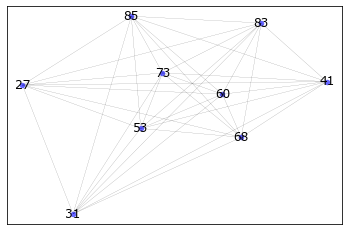

100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 9032.96it/s]


In [18]:
# Identify users’ communities in the Facebook network using Louvain
new_graph, communities_hypernodes, communities_nodes = louvain(graph)

In [19]:
print(f'There are {len(set(communities_nodes[-1].values()))} communities.')
print(communities_nodes[-1])

There are 9 communities.
{'0': '68', '3': '41', '7': '60', '8': '73', '18': '41', '20': '60', '37': '68', '38': '83', '49': '68', '52': '85', '65': '68', '66': '68', '70': '53', '74': '68', '83': '83', '1': '60', '2': '60', '12': '60', '19': '60', '21': '53', '22': '27', '33': '60', '34': '31', '35': '73', '39': '68', '42': '41', '48': '41', '50': '73', '57': '60', '64': '60', '67': '53', '82': '27', '93': '60', '9': '60', '15': '68', '16': '85', '29': '41', '40': '31', '41': '60', '47': '60', '54': '53', '56': '85', '58': '60', '60': '60', '78': '60', '80': '60', '85': '73', '92': '85', '97': '73', '10': '73', '26': '53', '28': '41', '44': '68', '46': '85', '51': '83', '61': '41', '62': '85', '72': '41', '90': '73', '4': '73', '13': '73', '14': '73', '30': '83', '55': '68', '59': '68', '71': '53', '73': '73', '77': '73', '88': '73', '91': '68', '95': '53', '99': '73', '5': '31', '17': '27', '31': '53', '32': '60', '36': '53', '63': '53', '6': '68', '24': '85', '53': '68', '68': '68', 

In [20]:
import community
louvain_communities = community.best_partition(graph)
nb_louvain_communities = len(set(louvain_communities.values()))
louvain_communities = {k: v for k, v in sorted(louvain_communities.items(), key=lambda item: item[0])} # sort by key (node id)
print(f'There are {nb_louvain_communities} communities according to Louvain\' method.')

dendo = community.generate_dendrogram(graph)
for level in range(len(dendo)) :
    print("partition at level", level, "is", community.partition_at_level(dendo, level))

There are 5 communities according to Louvain' method.
partition at level 0 is {'0': 0, '3': 1, '7': 0, '8': 2, '18': 2, '20': 0, '37': 3, '38': 4, '49': 0, '52': 1, '65': 5, '66': 6, '70': 7, '74': 3, '83': 6, '1': 6, '2': 8, '12': 3, '19': 8, '21': 6, '22': 5, '33': 9, '34': 4, '35': 9, '39': 7, '42': 3, '48': 10, '50': 9, '57': 6, '64': 6, '67': 4, '82': 9, '93': 6, '9': 8, '15': 4, '16': 1, '29': 2, '40': 9, '41': 8, '47': 0, '54': 7, '56': 1, '58': 2, '60': 9, '78': 8, '80': 8, '85': 3, '92': 6, '97': 1, '10': 9, '26': 7, '28': 9, '44': 2, '46': 1, '51': 5, '61': 7, '62': 1, '72': 9, '90': 2, '4': 2, '13': 8, '14': 8, '30': 6, '55': 2, '59': 5, '71': 7, '73': 0, '77': 9, '88': 3, '91': 0, '95': 7, '99': 3, '5': 9, '17': 9, '31': 6, '32': 0, '36': 0, '63': 0, '6': 5, '24': 6, '53': 5, '68': 5, '96': 0, '43': 6, '84': 10, '86': 10, '45': 1, '75': 2, '89': 9, '94': 8, '98': 6, '11': 5, '25': 9, '81': 3, '69': 4, '23': 4, '76': 10, '27': 9, '79': 0, '87': 7}
partition at level 1 is {'0

In [21]:
# Identify the top k users with the highest clustering coefficient in the graph.
# Experiment with different values of k and choose the most appropriate one.
print('Average clustering coefficient:', average_clustering_coefficient(graph))
print('Top k=3 users with highest clustering coefficients:', clustering_coefficient(graph, top_k=3))

Average clustering coefficient: 0.19347384796375308
Top k=3 users with highest clustering coefficients: {'73': 0.2878787878787879, '52': 0.25, '46': 0.24736842105263157}


In [22]:
nx.clustering(graph)

{'0': 0.1978021978021978,
 '3': 0.2087912087912088,
 '7': 0.15584415584415584,
 '8': 0.19607843137254902,
 '18': 0.19047619047619047,
 '20': 0.19658119658119658,
 '37': 0.1956521739130435,
 '38': 0.17142857142857143,
 '49': 0.17666666666666667,
 '52': 0.25,
 '65': 0.1761904761904762,
 '66': 0.22058823529411764,
 '70': 0.16304347826086957,
 '74': 0.16996047430830039,
 '83': 0.19166666666666668,
 '1': 0.17316017316017315,
 '2': 0.18478260869565216,
 '12': 0.18571428571428572,
 '19': 0.17647058823529413,
 '21': 0.19202898550724637,
 '22': 0.16176470588235295,
 '33': 0.18181818181818182,
 '34': 0.22631578947368422,
 '35': 0.2,
 '39': 0.20915032679738563,
 '42': 0.18382352941176472,
 '48': 0.21739130434782608,
 '50': 0.19480519480519481,
 '57': 0.20833333333333334,
 '64': 0.19367588932806323,
 '67': 0.16176470588235295,
 '82': 0.22134387351778656,
 '93': 0.1737891737891738,
 '9': 0.18840579710144928,
 '15': 0.15714285714285714,
 '16': 0.18947368421052632,
 '29': 0.20915032679738563,
 '40': 

In [23]:
# Evaluate different random walk strategies to spread a message across the network.
# The message should reach as many different communities as possible.
starting_node = list(graph.nodes())[0]
steps = 10
rw_result_strategy_degree = random_walk(graph, starting_node, steps, rw_strategy_degree)
rw_result_strategy_random = random_walk(graph, starting_node, steps, rw_strategy_random)
rw_result_stategy_connected_neighbors = random_walk(graph, starting_node, steps, rw_strategy_connected_neighbors)

print('Percentage of visited communities with the degree based rw strategy:', percentage_visited_communities(rw_result_strategy_degree, communities_nodes[-1]), '%')
print('Percentage of visited communities with full random rw strategy:', percentage_visited_communities(rw_result_strategy_random, communities_nodes[-1]), '%')
print('Percentage of visited communities with the connected neighbors rw strategy:' ,percentage_visited_communities(rw_result_stategy_connected_neighbors, communities_nodes[-1]), '%')

Percentage of visited communities with the degree based rw strategy: 44.44444444444444 %
Percentage of visited communities with full random rw strategy: 66.66666666666666 %
Percentage of visited communities with the connected neighbors rw strategy: 77.77777777777779 %


## Visualization

In [24]:
def draw_communities(graph, communities, pos_param=None):
    nodes_community = [int(community) for community in communities.values()]
    if pos_param:
        nx.draw(graph, cmap=plt.get_cmap('viridis'), node_color=nodes_community, with_labels=True, font_color='white', pos=pos_param)
    else:
        nx.draw(graph, cmap=plt.get_cmap('viridis'), node_color=nodes_community, with_labels=True, font_color='white')
    plt.show()

In [25]:
def draw_path(graph, path, pos_param=None):
    edges_path = []
    for i in range(len(path)-1):
        edges_path.append((path[i], path[i+1]))
    pos = nx.spring_layout(graph)
    if pos_param:
        pos = pos_param
    nx.draw(graph, pos=pos, with_labels=True)
    nx.draw_networkx_nodes(graph, pos, nodelist=path[1:], node_color='r')
    nx.draw_networkx_nodes(graph, pos, nodelist=[path[0]], node_color='g')
    nx.draw_networkx_edges(graph, pos, edgelist=edges_path, width=2.0, edge_color='r')

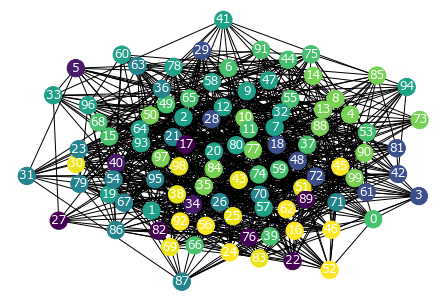

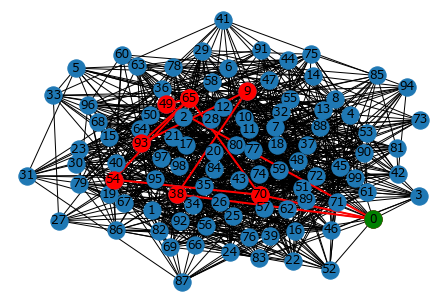

In [26]:
pos = nx.spring_layout(graph)

# Visualize the output of Louvain by coloring the nodes according to their assigned Communities.
draw_communities(graph, communities_nodes[-1], pos)

# Visualize the output of applying Random Walk algorithm, by highlighting the sequence of nodes selected in a path.
draw_path(graph, rw_result_strategy_degree, pos)